In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
saved_dict = {}
file_path = 'UNSW Dataset for Testing\\NUSW-NB15_features.csv'
df_col = pd.read_csv(file_path,encoding = 'ISO-8859-1')

In [3]:
df_col['Name'] = df_col['Name'].apply(lambda x: x.strip().replace(' ','').lower()) # column names become lowercase and removing spaces 

In [4]:
df = pd.read_csv('UNSW Dataset for Testing\\UNSW-NB15_1.csv')

C:\Users\Khush Bhuta\AppData\Local\Temp\ipykernel_22856\4094917072.py:1: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('UNSW Dataset for Testing\\UNSW-NB15_1.csv')


In [5]:
saved_dict['columns'] = df_col['Name'][df_col['Name']!='label'].tolist()

In [6]:
df.columns = df_col['Name']

In [7]:
df['attack_cat'] = df.attack_cat.fillna(value = 'normal').apply(lambda x: x.strip().lower())

In [8]:
numeric_columns = ['dur','sbytes','dbytes','sloss','dloss','spkts','dpkts','swin','dwin','sintpkt','dintpkt']
non_numeric_columns = ['attack_cat','label']
data = pd.DataFrame()
data = df[['dur','sbytes','dbytes','sloss','dloss','spkts','dpkts','swin','dwin','sintpkt','dintpkt','attack_cat','label']]
data

Name,dur,sbytes,dbytes,sloss,dloss,spkts,dpkts,swin,dwin,sintpkt,dintpkt,attack_cat,label
0,0.036133,528,304,0,0,4,4,0,0,7.005000,7.564333,normal,0
1,0.001119,146,178,0,0,2,2,0,0,0.017000,0.013000,normal,0
2,0.001209,132,164,0,0,2,2,0,0,0.043000,0.014000,normal,0
3,0.001169,146,178,0,0,2,2,0,0,0.005000,0.003000,normal,0
4,0.078339,568,312,0,0,4,4,0,0,21.003000,24.315000,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
699995,0.020383,320,1874,1,2,6,8,255,255,4.007400,2.027429,normal,0
699996,1.402957,19410,1087890,2,370,364,746,255,255,3.864028,1.882421,normal,0
699997,0.007108,2158,2464,6,6,24,24,255,255,0.274261,0.285478,normal,0
699998,0.004435,568,304,0,0,4,4,0,0,1.165667,0.987333,normal,0


In [9]:
from scipy.fft import fft
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report

def apply_fft(df,columns):
    fft_features = pd.DataFrame()
    for col in columns:
        fft_values = np.abs(fft(df[col].values))
        fft_features[col+'_fft'] = fft_values[:len(fft_values)]
    return fft_features

In [10]:
fft_data = apply_fft(data,numeric_columns)
fft_data.shape

(700000, 11)

In [11]:
# Get unique values in 'attack_cat' column as a numpy array
anomalous_categories = data['attack_cat'].unique()

# Convert numpy array to list and remove 'normal'
anomalous_categories = anomalous_categories.tolist()
anomalous_categories.remove('normal')

print(anomalous_categories)


['exploits', 'reconnaissance', 'dos', 'generic', 'shellcode', 'fuzzers', 'worms', 'backdoors', 'analysis']


In [12]:
# clf_dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 22, min_samples_split = 4, random_state = None)
clf_dt = DecisionTreeClassifier(class_weight = None, criterion = 'gini', max_depth = 22,
                                                         max_features = 20, max_leaf_nodes = None,
                                                         min_impurity_decrease = 0.0,
                                                         min_samples_leaf = 1, min_samples_split = 4,
                                                         min_weight_fraction_leaf = 0.0,
                                                         random_state = None, splitter = 'best')
# clf_rf = RandomForestClassifier(n_estimators = 75, criterion = 'entropy', min_samples_split = 10, random_state = None)
clf_rf = RandomForestClassifier(bootstrap = True, class_weight = None,
                                                         criterion = 'gini', min_impurity_decrease=0.0,
                                                         min_samples_leaf = 1, min_samples_split = 10,
                                                         min_weight_fraction_leaf = 0.0, n_estimators = 70,
                                                         n_jobs = None, oob_score = False, random_state = None,
                                                         verbose = 0, warm_start = False)

In [14]:
test_data = data.sample(frac = 0.2, random_state = 42)
X_test = test_data.drop(columns = non_numeric_columns)
y_test = test_data['label'] # since we are performing only binary classification
train_data = data.drop(test_data.index)
train_subsets = []

In [15]:
for i in range(1,len(anomalous_categories) + 1):
    included_categories = anomalous_categories[:i] # all attack-cat included 
    excluded_categories = anomalous_categories[i:] # all attack_cat excluded

    condition_included = train_data['attack_cat'].isin(included_categories)
    condition_normal = train_data['label'] == 0

    subset = train_data.loc[condition_included | condition_normal]
    train_subsets.append((subset,excluded_categories))

In [16]:
results = {}

--Experiment with 1 anomalous categories in training data: --
Excluded Categories = ['reconnaissance', 'dos', 'generic', 'shellcode', 'fuzzers', 'worms', 'backdoors', 'analysis']
Metrics for training with 1 anomalous categories: 
Accuracy: 0.9807
Precision: 0.9731
Recall: 0.7106
F1_Score: 0.7885


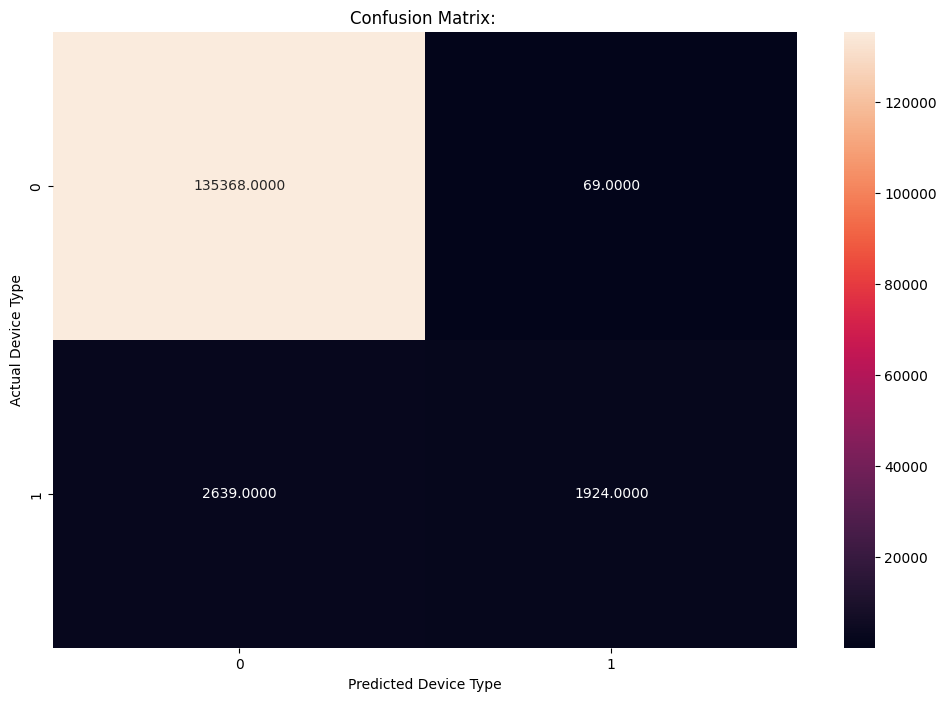

--Experiment with 2 anomalous categories in training data: --
Excluded Categories = ['dos', 'generic', 'shellcode', 'fuzzers', 'worms', 'backdoors', 'analysis']
Metrics for training with 2 anomalous categories: 
Accuracy: 0.9829
Precision: 0.9705
Recall: 0.7477
F1_Score: 0.8224


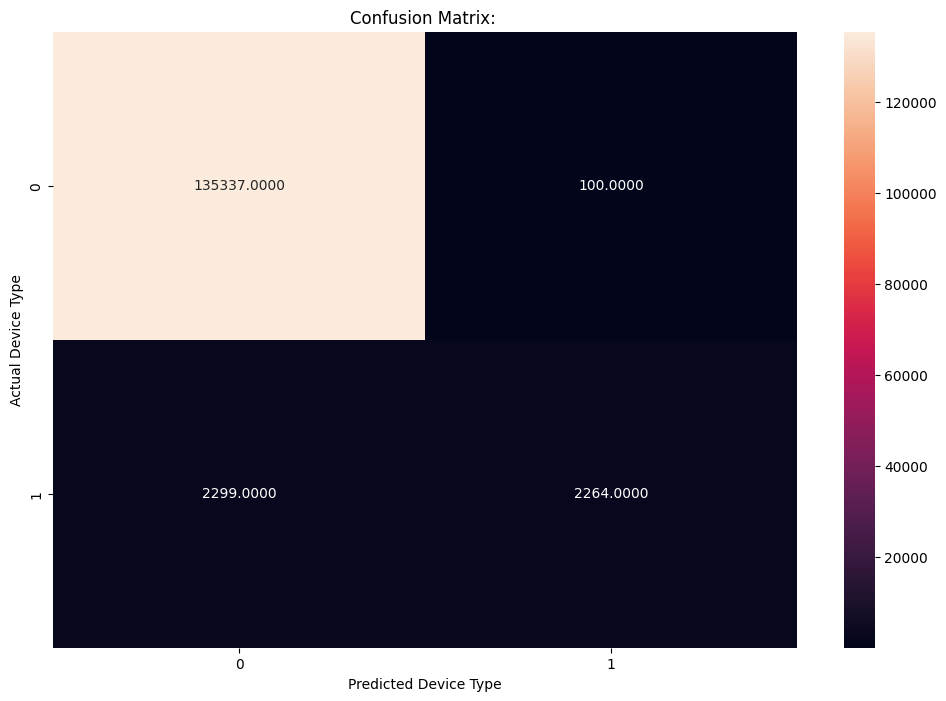

--Experiment with 3 anomalous categories in training data: --
Excluded Categories = ['generic', 'shellcode', 'fuzzers', 'worms', 'backdoors', 'analysis']
Metrics for training with 3 anomalous categories: 
Accuracy: 0.9888
Precision: 0.9806
Recall: 0.8382
F1_Score: 0.8962


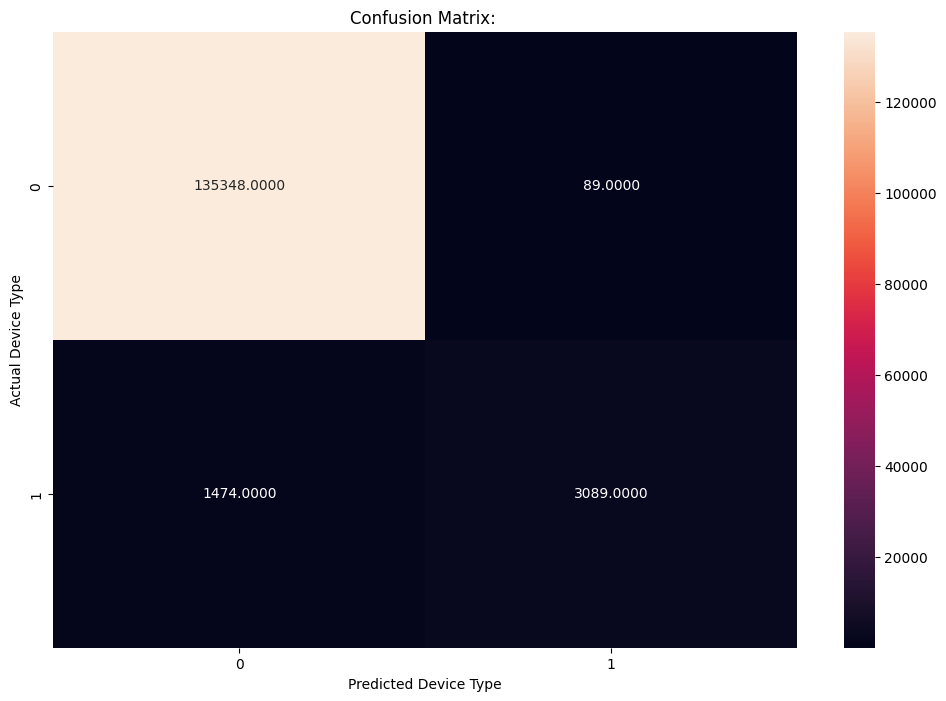

--Experiment with 4 anomalous categories in training data: --
Excluded Categories = ['shellcode', 'fuzzers', 'worms', 'backdoors', 'analysis']
Metrics for training with 4 anomalous categories: 
Accuracy: 0.9932
Precision: 0.9831
Recall: 0.9064
F1_Score: 0.9412


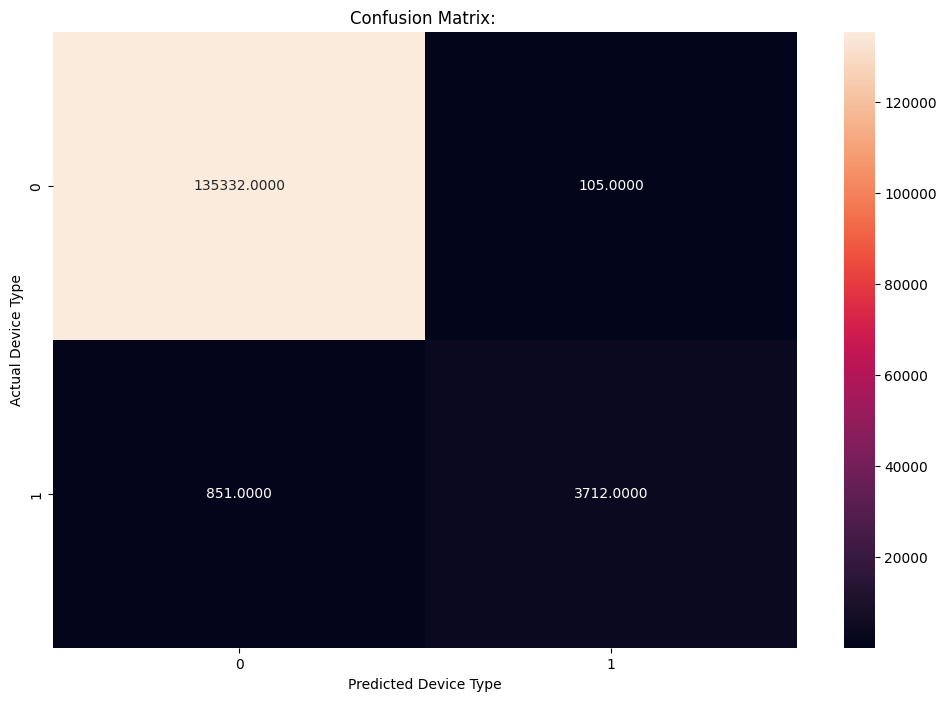

--Experiment with 5 anomalous categories in training data: --
Excluded Categories = ['fuzzers', 'worms', 'backdoors', 'analysis']
Metrics for training with 5 anomalous categories: 
Accuracy: 0.9935
Precision: 0.9827
Recall: 0.9121
F1_Score: 0.9445


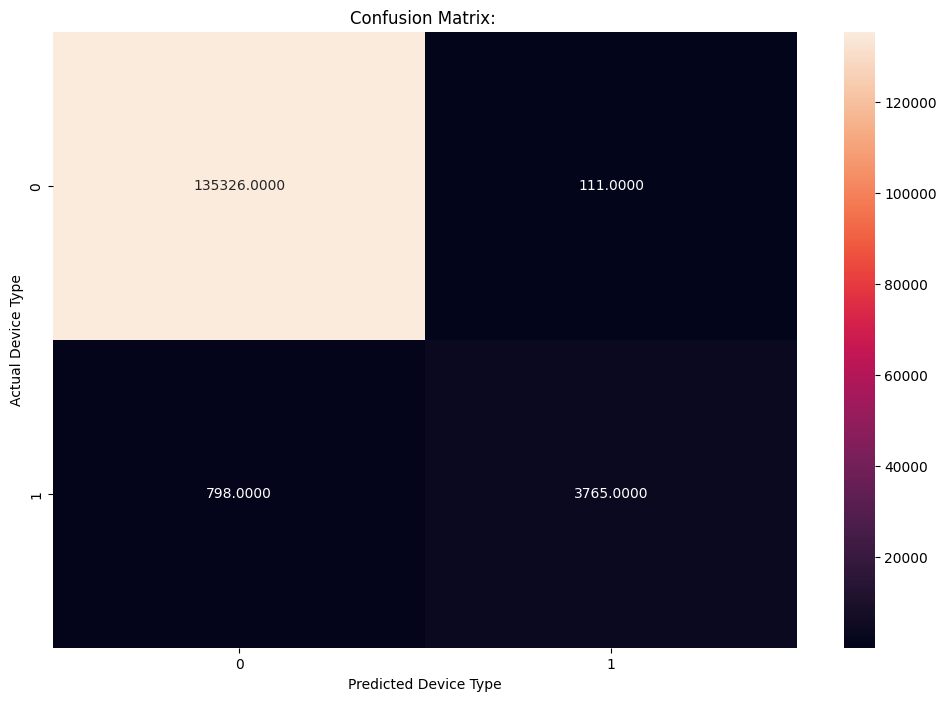

--Experiment with 6 anomalous categories in training data: --
Excluded Categories = ['worms', 'backdoors', 'analysis']
Metrics for training with 6 anomalous categories: 
Accuracy: 0.9952
Precision: 0.9633
Recall: 0.9607
F1_Score: 0.9620


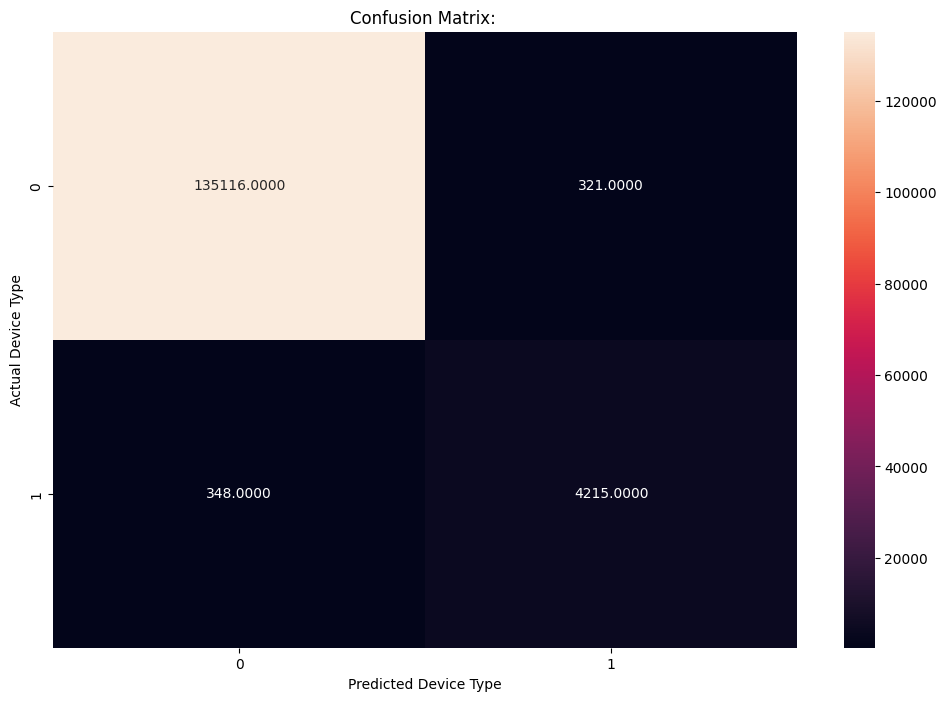

--Experiment with 7 anomalous categories in training data: --
Excluded Categories = ['backdoors', 'analysis']
Metrics for training with 7 anomalous categories: 
Accuracy: 0.9952
Precision: 0.9632
Recall: 0.9603
F1_Score: 0.9618


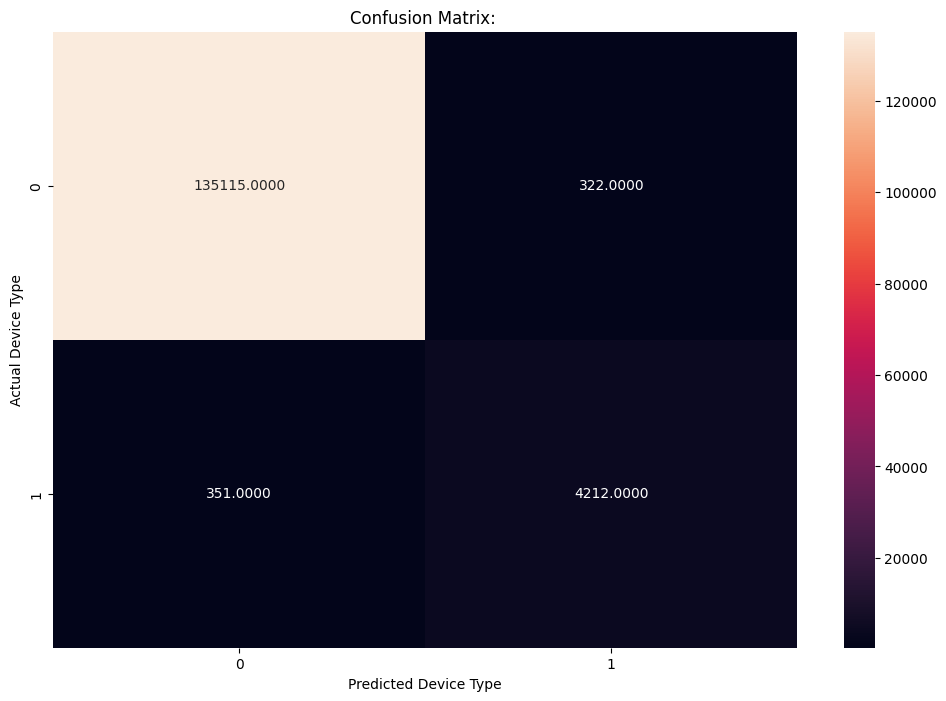

--Experiment with 8 anomalous categories in training data: --
Excluded Categories = ['analysis']
Metrics for training with 8 anomalous categories: 
Accuracy: 0.9952
Precision: 0.9633
Recall: 0.9608
F1_Score: 0.9621


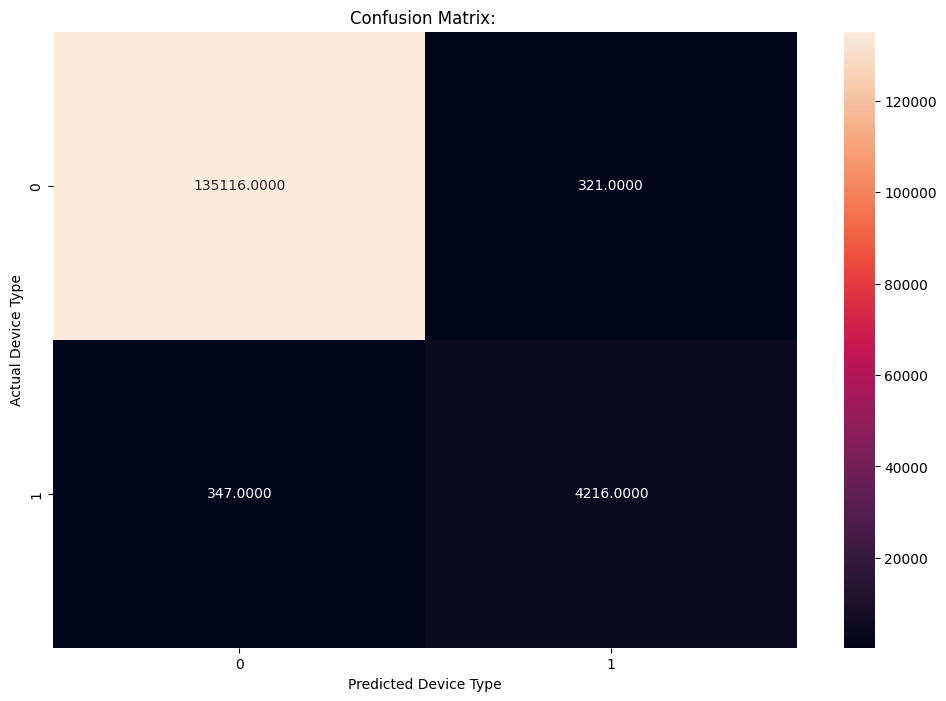

--Experiment with 9 anomalous categories in training data: --
Excluded Categories = None
Metrics for training with 9 anomalous categories: 
Accuracy: 0.9952
Precision: 0.9632
Recall: 0.9605
F1_Score: 0.9618


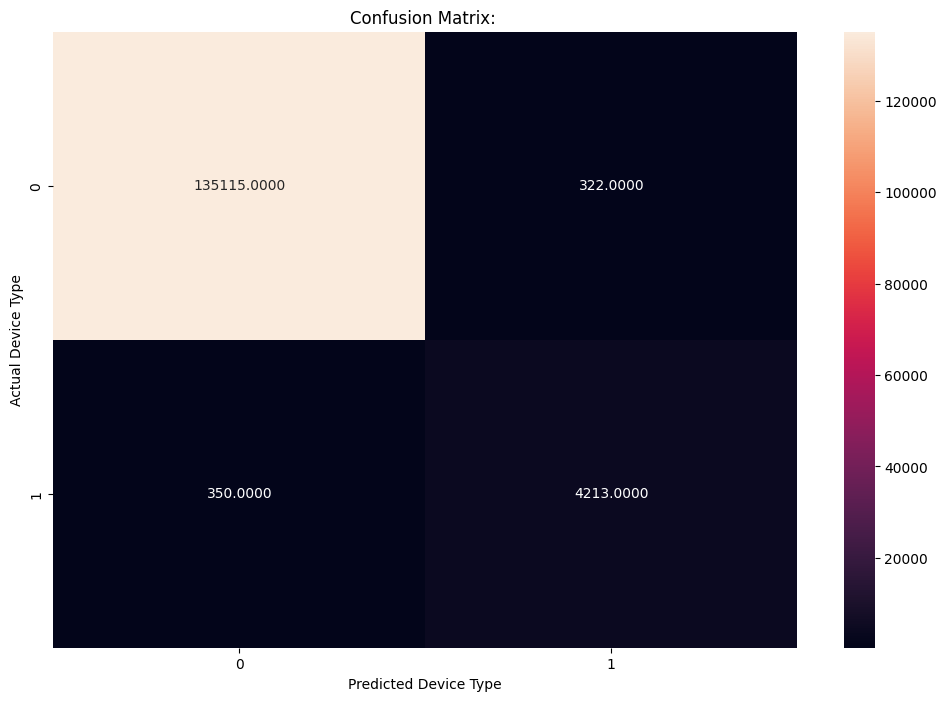

In [17]:
for i, (subset,excluded_categories) in enumerate(train_subsets,start = 1):
    print(f"--Experiment with {i} anomalous categories in training data: --")
    print(f"Excluded Categories = {excluded_categories if excluded_categories else 'None'}")

    X_train = subset.drop(columns = ['attack_cat','label'])
    y_train = subset['label']
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.fit_transform(y_test)

    clf_dt.fit(X_train,y_train)
    y_pred = clf_dt.predict(X_test)

    accuracy = metrics.accuracy_score(y_test,y_pred)
    precision = metrics.precision_score(y_test, y_pred, average = 'macro')
    recall = metrics.recall_score(y_test, y_pred, average = 'macro')
    f1_score = metrics.f1_score(y_test,y_pred,average='macro')
    
    # printing the metrics (macro values for precision, recall and F1-Score)
    print(f'Metrics for training with {i} anomalous categories: ')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1_Score: {f1_score:.4f}')

    # creating a confusion matrix 
    cnf_matrix_dt = metrics.confusion_matrix(y_test,y_pred)
    normalized_cnf_matrix_dt = cnf_matrix_dt.astype('float')/cnf_matrix_dt.sum(axis = 1)[:,np.newaxis] 
    plt.figure(figsize = (12,8))
    sns.heatmap(cnf_matrix_dt,annot = True,fmt = '.4f',
               xticklabels = label_encoder.classes_,
               yticklabels = label_encoder.classes_)
    plt.xlabel('Predicted Device Type')
    plt.ylabel('Actual Device Type')
    plt.title(f'Confusion Matrix: ')
    plt.show()

--Experiment with 1 anomalous categories in training data: --
Excluded Categories = ['reconnaissance', 'dos', 'generic', 'shellcode', 'fuzzers', 'worms', 'backdoors', 'analysis']
Metrics for training with 1 anomalous categories: 
Accuracy: 0.9807
Precision: 0.9790
Recall: 0.7079
F1_Score: 0.7869


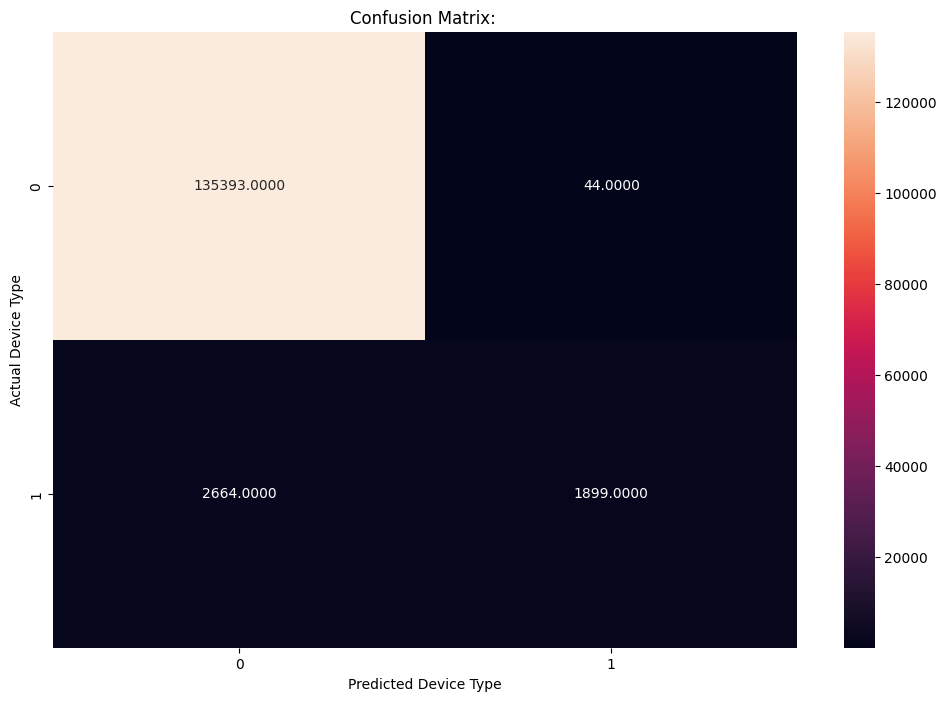

--Experiment with 2 anomalous categories in training data: --
Excluded Categories = ['dos', 'generic', 'shellcode', 'fuzzers', 'worms', 'backdoors', 'analysis']
Metrics for training with 2 anomalous categories: 
Accuracy: 0.9827
Precision: 0.9796
Recall: 0.7404
F1_Score: 0.8179


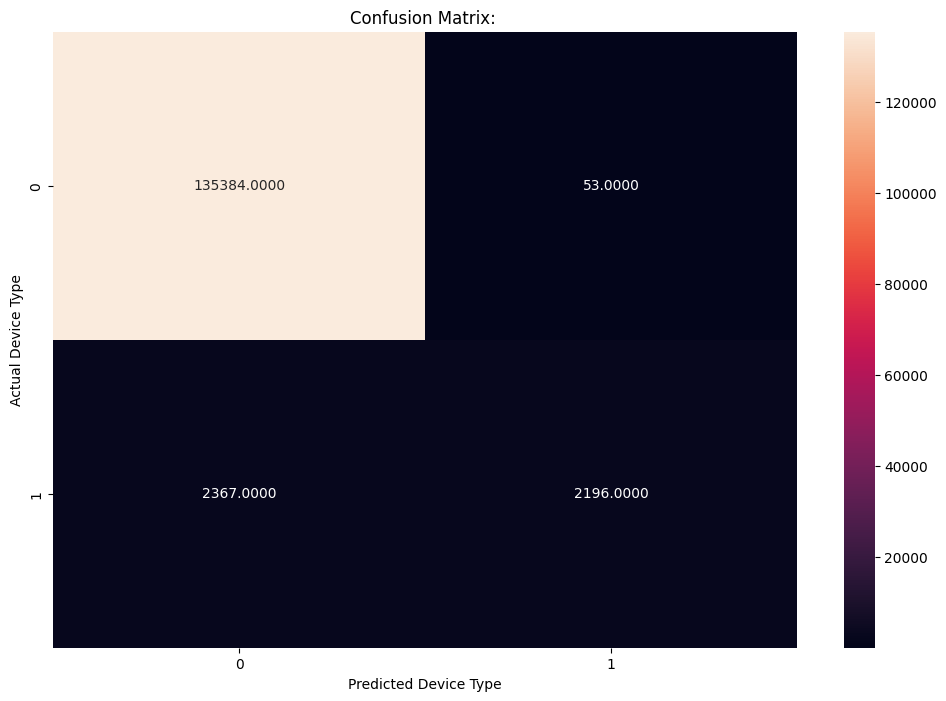

--Experiment with 3 anomalous categories in training data: --
Excluded Categories = ['generic', 'shellcode', 'fuzzers', 'worms', 'backdoors', 'analysis']
Metrics for training with 3 anomalous categories: 
Accuracy: 0.9878
Precision: 0.9831
Recall: 0.8191
F1_Score: 0.8832


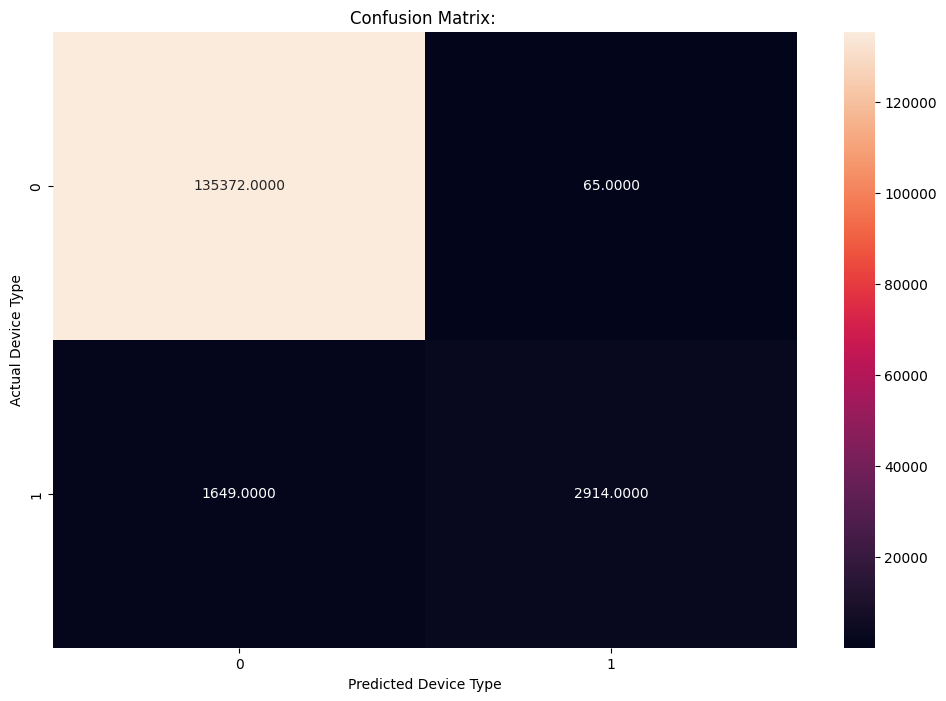

--Experiment with 4 anomalous categories in training data: --
Excluded Categories = ['shellcode', 'fuzzers', 'worms', 'backdoors', 'analysis']
Metrics for training with 4 anomalous categories: 
Accuracy: 0.9935
Precision: 0.9867
Recall: 0.9083
F1_Score: 0.9438


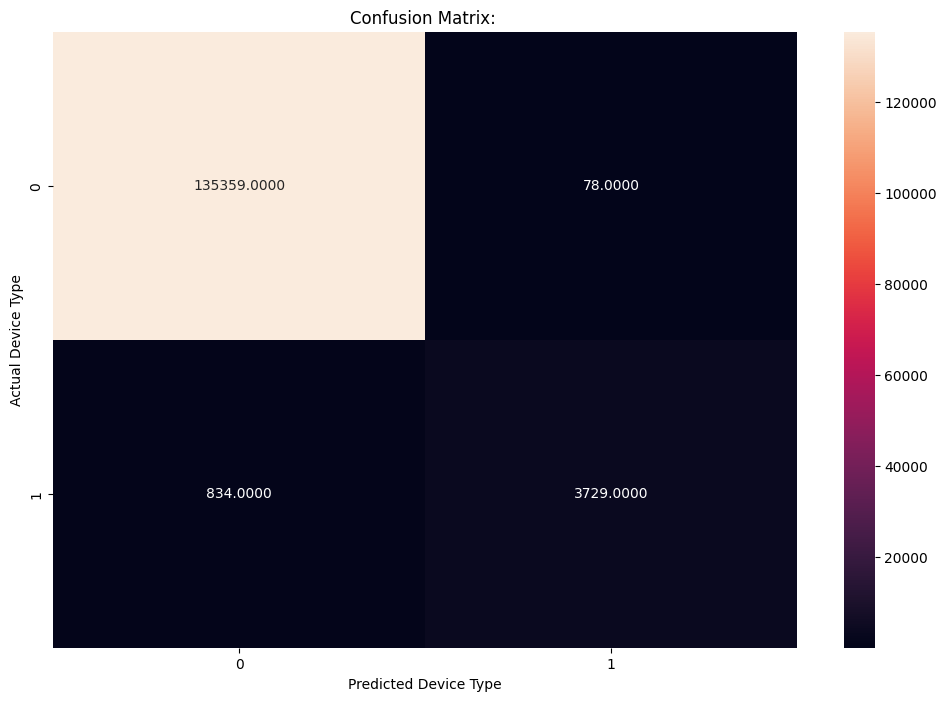

--Experiment with 5 anomalous categories in training data: --
Excluded Categories = ['fuzzers', 'worms', 'backdoors', 'analysis']
Metrics for training with 5 anomalous categories: 
Accuracy: 0.9937
Precision: 0.9865
Recall: 0.9112
F1_Score: 0.9454


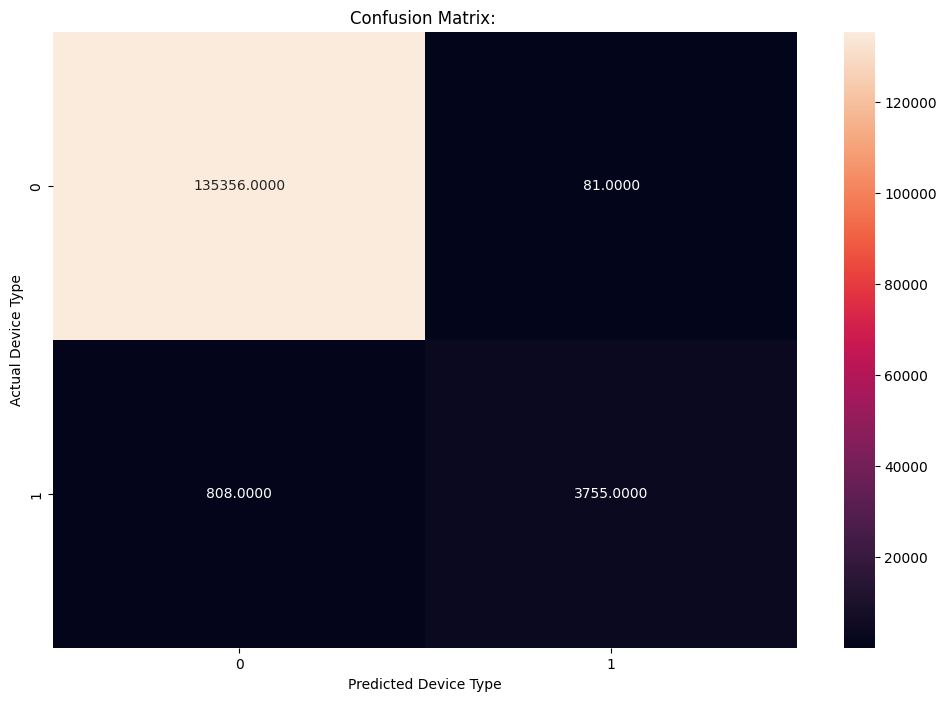

--Experiment with 6 anomalous categories in training data: --
Excluded Categories = ['worms', 'backdoors', 'analysis']
Metrics for training with 6 anomalous categories: 
Accuracy: 0.9962
Precision: 0.9683
Recall: 0.9712
F1_Score: 0.9697


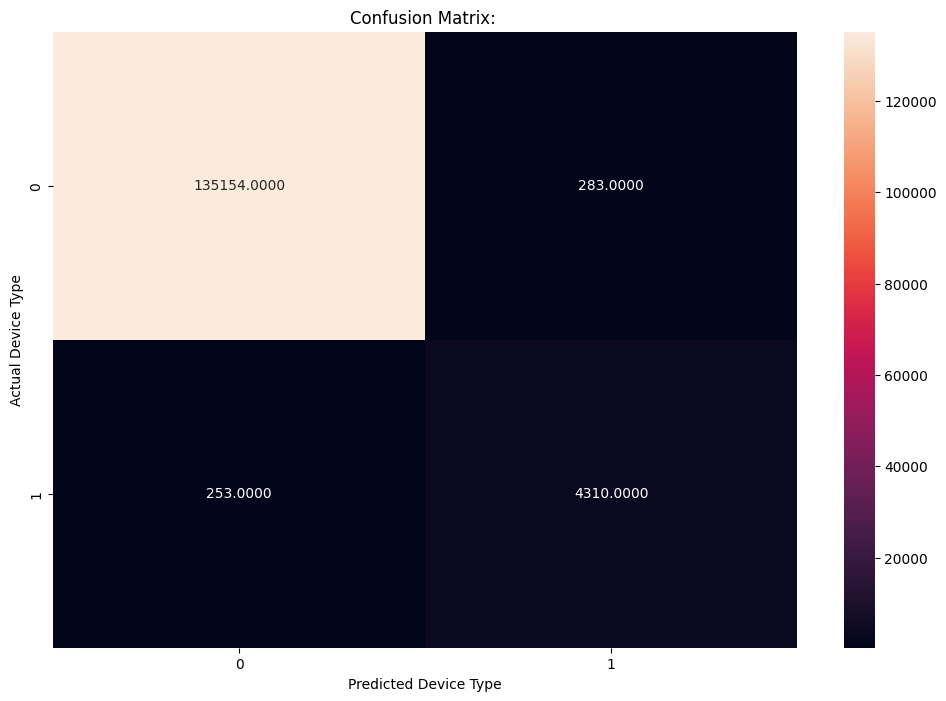

--Experiment with 7 anomalous categories in training data: --
Excluded Categories = ['backdoors', 'analysis']
Metrics for training with 7 anomalous categories: 
Accuracy: 0.9961
Precision: 0.9680
Recall: 0.9705
F1_Score: 0.9692


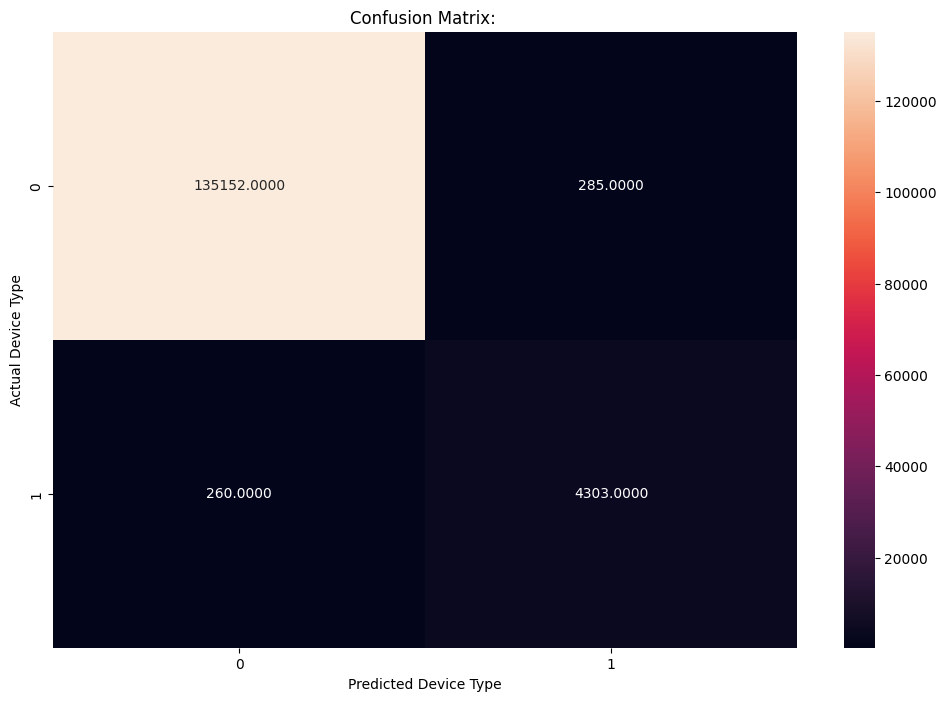

--Experiment with 8 anomalous categories in training data: --
Excluded Categories = ['analysis']
Metrics for training with 8 anomalous categories: 
Accuracy: 0.9961
Precision: 0.9668
Recall: 0.9711
F1_Score: 0.9689


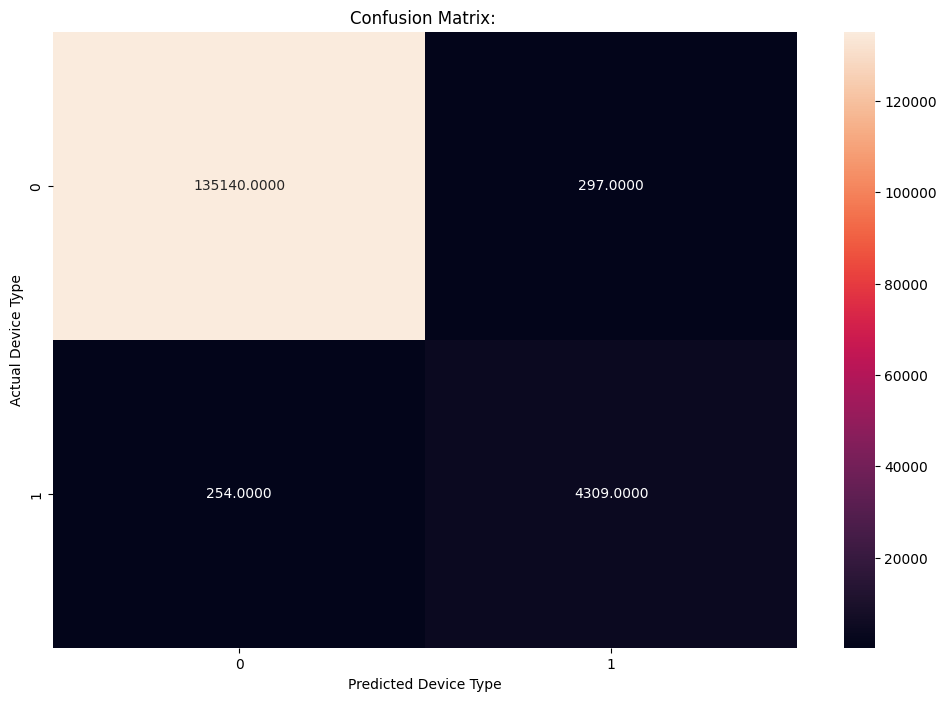

--Experiment with 9 anomalous categories in training data: --
Excluded Categories = None
Metrics for training with 9 anomalous categories: 
Accuracy: 0.9961
Precision: 0.9680
Recall: 0.9710
F1_Score: 0.9695


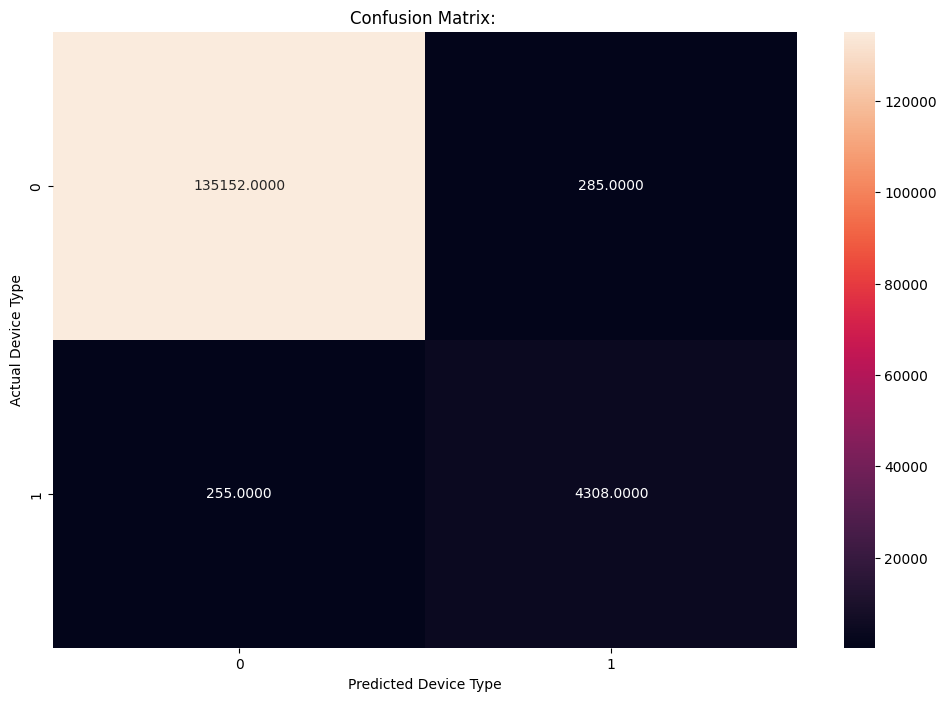

In [18]:
for i, (subset,excluded_categories) in enumerate(train_subsets,start = 1):
    print(f"--Experiment with {i} anomalous categories in training data: --")
    print(f"Excluded Categories = {excluded_categories if excluded_categories else 'None'}")

    X_train = subset.drop(columns = ['attack_cat','label'])
    y_train = subset['label']
    clf_rf.fit(X_train,y_train)
    y_pred = clf_rf.predict(X_test)

    accuracy = metrics.accuracy_score(y_test,y_pred)
    precision = metrics.precision_score(y_test, y_pred, average = 'macro')
    recall = metrics.recall_score(y_test, y_pred, average = 'macro')
    f1_score = metrics.f1_score(y_test,y_pred,average='macro')
    
    # printing the metrics (macro values for precision, recall and F1-Score)
    print(f'Metrics for training with {i} anomalous categories: ')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1_Score: {f1_score:.4f}')

    # creating a confusion matrix 
    cnf_matrix_rf = metrics.confusion_matrix(y_test,y_pred)
    normalized_cnf_matrix_rf = cnf_matrix_rf.astype('float')/cnf_matrix_rf.sum(axis = 1)[:,np.newaxis] 
    plt.figure(figsize = (12,8))
    sns.heatmap(cnf_matrix_rf,annot = True,fmt = '.4f',
               xticklabels = label_encoder.classes_,
               yticklabels = label_encoder.classes_)
    plt.xlabel('Predicted Device Type')
    plt.ylabel('Actual Device Type')
    plt.title(f'Confusion Matrix: ')
    plt.show()